In [1]:
#pip install tensorflow==1.13.2

In [2]:
pip install stable_baselines

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [4]:
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2, A2C, ACKTR
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import results_plotter

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [5]:
class NoisedObservationWrapper(gym.ObservationWrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))
    
    def __init__(self, env, std_dev=0.1, mean=0):
        super(NoisedObservationWrapper, self).__init__(env)
        self.std_dev = std_dev
        self.mean = mean
      
    def observation(self, observation):
        # Modify observation here, e.g. just add noise at certain angles etc.
        # for now we add noise with mu=0 and std=0.1 on all observations
        return observation + np.random.normal(self.mean, self.std_dev, 4)


def sample_data(env, episodes=200, save=False):
    env.np_random.seed(0)

    CART_POS="cartPos"
    CART_VEL="cartVel"
    PEND_POS="pendPos"
    PEND_VEL="pendVel"
    EPISODE="episode"
    STEP="step"
    ACTION="action"

    # create empty Pandas dataset
    d = {
        CART_POS:[], CART_VEL:[], 
        PEND_POS:[], PEND_VEL:[],
        EPISODE:[], STEP:[], ACTION:[]
        }
    df = pd.DataFrame(data=d)

    # sample data
    for episode in range(episodes):
        print ("Start of episode %d" % episode)
        obs = env.reset()
        step = 0
        done = False
        
        while step < 500 and not done:
            step += 1
            action = env.action_space.sample()
            
            df = df.append ({CART_POS:obs[0], CART_VEL:obs[1], 
                            PEND_POS:obs[2], PEND_VEL:obs[3],
                            EPISODE:episode, STEP:step, ACTION:action}, ignore_index=True)
            
            obs, reward, done, _ = env.step(action)
    
    if save:
        store = pd.HDFStore('sample_data.h5')
        store['df'] = df
    
    return df

In [6]:
log_dir1 = "logs1"
log_dir2 = "logs2"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)

In [7]:
env1 = gym.make('CartPole-v1')
env1 = Monitor(env1, log_dir1) # required for using callback functions during training

In [8]:
env2 = NoisedObservationWrapper(gym.make("CartPole-v0"))
env2 = Monitor(env2, log_dir2) # required for using callback functions during training

In [9]:
from stable_baselines.common.callbacks import BaseCallback
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param avg_episodes: (int) average over the past n episodes (default: 100)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    :param vec_norm_env: (VecNormalize) stable-baselines VecNormalize object (contains Gym env)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1, avg_episodes=100, vec_norm_env=None):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model_nn')
        self.best_mean_reward = -np.inf
        self.best_timestep = -np.inf
        self.vec_norm_env = vec_norm_env
        self.avg_episodes = avg_episodes

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                # Mean training reward over the last avg_episodes episodes
                mean_reward = np.mean(y[-self.avg_episodes:])

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.best_timestep = self.num_timesteps
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                    self.model.save(self.save_path)

                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} (ts={}) - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, self.best_timestep, mean_reward))


        return True

In [10]:
time_steps=21000

tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
model1 = PPO2(MlpPolicy, env1, verbose=0)
callback1=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir1, avg_episodes=30, vec_norm_env=env1)
model1.learn(total_timesteps=time_steps, callback=callback1)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Saving new best model to logs1/best_model_nn
Num timesteps: 5000
Best mean reward: 77.60 (ts=5000) - Last mean reward per episode: 77.60
Saving new best model to logs1/best_model_nn
Num timesteps: 10000
Best mean reward: 128.47 (ts=10000) - Last mean reward per episode: 128.47
Saving new best model to logs1/best_model_nn
Num timesteps: 15000
Best mean reward: 130.73 (ts=15000) - Last mean reward per episode: 130.73
Saving new best model to logs1/best_model_nn
Num timesteps: 20000
Best mean reward: 154.70 (ts=20000) - Last mean reward per episode: 154.70


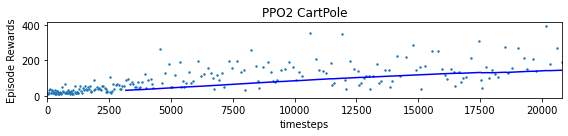

In [11]:
results_plotter.plot_results([log_dir1], time_steps, results_plotter.X_TIMESTEPS, "PPO2 CartPole")
plt.savefig("results1-cartpole.png")
plt.show()

In [12]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
model2 = PPO2(MlpPolicy, env2, verbose=0)
callback2=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir2, avg_episodes=30, vec_norm_env=env2)
model2.learn(total_timesteps=time_steps, callback=callback2)

Saving new best model to logs2/best_model_nn
Num timesteps: 5000
Best mean reward: 82.00 (ts=5000) - Last mean reward per episode: 82.00
Saving new best model to logs2/best_model_nn
Num timesteps: 10000
Best mean reward: 102.43 (ts=10000) - Last mean reward per episode: 102.43
Saving new best model to logs2/best_model_nn
Num timesteps: 15000
Best mean reward: 151.47 (ts=15000) - Last mean reward per episode: 151.47
Saving new best model to logs2/best_model_nn
Num timesteps: 20000
Best mean reward: 155.77 (ts=20000) - Last mean reward per episode: 155.77


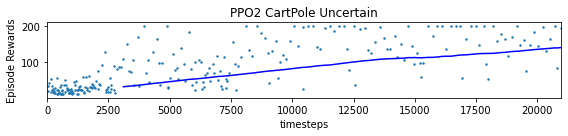

In [13]:
results_plotter.plot_results([log_dir2], time_steps, results_plotter.X_TIMESTEPS, "PPO2 CartPole Uncertain")
plt.savefig("results2-cartpole.png")
plt.show()

In [22]:
import torch as torch
import torch.nn as nn

from torch.distributions.normal import Normal
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.nn import Module
from torch.nn.modules import activation
import math
from tqdm import tqdm

In [14]:
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])


In [8]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0, 1)

    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))

    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(self.device)
        return self.mu + self.sigma * epsilon

    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [9]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0, sigma1)
        self.gaussian2 = torch.distributions.Normal(0, sigma2)

    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1 - self.pi) * prob2)).sum()

In [10]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)

        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0


    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [20]:
SAMPLES = 100
PI = 0.5
TRAIN_EPOCHS = 500

In [16]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28 * 28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)

    def forward(self, x, sample=False):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior

    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior

    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES)
        log_priors = torch.zeros(samples)
        log_variational_posteriors = torch.zeros(samples)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior) / NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [17]:
net = BayesianNetwork()

In [18]:
def train(net, optimizer, epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        net.zero_grad()
        loss = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()

In [23]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

NameError: ignored